In [1]:
import numpy as np

from qiskit import IBMQ, Aer, QuantumCircuit, execute

from qiskit.visualization import plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.circuit.library.standard_gates import RXGate, RYGate
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.components.optimizers import AQGD, COBYLA

%matplotlib inline

Getting a noise model from an actual quantum backend. Not yet used.

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_vigo")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter)

Setting the target distribution to obtain either $\left|01\right>$ or $\left|10\right>$ with 50% probability each.

In [3]:
target_distribution = np.array([0., 0.5, 0.5, 0.])

I could have used qiskit's `TwoLocal` class to create the ansatz but decided that 8 parameters
(the smallest number possible when using `TwoLocal`) are too many for the purposes of this task. That is why I went for creating my own variational form.

In [4]:
def variational_form(params):
    NUM_QUBITS = 2
    NUM_CLBITS = 2
    gates = [RXGate, RYGate]
    vf = QuantumCircuit(NUM_QUBITS, NUM_CLBITS)

    for q, param in enumerate(params):
        vf.append(gates[(q // NUM_QUBITS) % 2](param), [q % NUM_QUBITS])
    vf.cx(0, 1)
    vf.measure(0, 0)
    vf.measure(1, 1)
    
    return vf

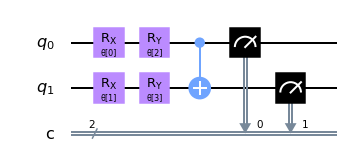

In [5]:
form = variational_form(ParameterVector(u'θ', 4))
display(form.draw("mpl"))

In [6]:
def probability_distribution(counts, shots=1000):
    labels = ["00", "01", "10", "11"]
    ordered_counts = np.array([counts[label] if label in counts.keys() else 0 for label in labels])
    distribution = ordered_counts / shots
    
    return distribution

def objective_function(params, shots=1000):
    qc = variational_form(params)
    result = execute(qc, backend, shots=shots).result()
    output_distribution = probability_distribution(result.get_counts(qc), shots)
    
    return sum(np.abs(output_distribution - target_distribution))

Setting a random starting point.

In [7]:
initial_point = np.array([np.random.uniform(-np.pi, np.pi) for i in range(4)])
initial_point

array([-1.82600877, -0.85820905, -1.02291123,  2.37430675])

Qiskit's `COBYLA` optimizer works well and converges quickly around the solution but it's gradient-free.

In [8]:
optimizer = COBYLA(maxiter=1000, tol=1e-6)

(p, v, n) = optimizer.optimize(num_vars=4, objective_function=objective_function,
                               initial_point=initial_point)

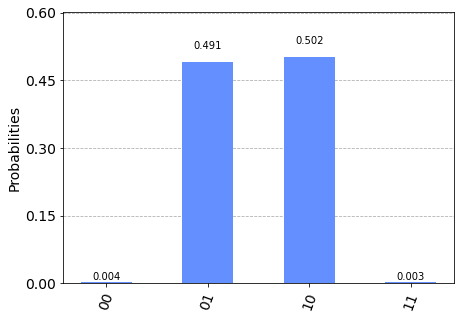

In [9]:
optimized_qc = variational_form(p)

result = execute(optimized_qc, backend, shots=1000).result()
plot_histogram(result.get_counts())

In [10]:
print("End point: {}, remaining cost: {}, iterations: {}".format(p, v, n))

End point: [-1.08415239  0.0573789  -1.53624531  3.23536928], remaining cost: 0.010000000000000005, iterations: 67


My implementation of the stochastic gradient descent (SGD) is mostly based on [Sweke et al](https://arxiv.org/pdf/1910.01155.pdf). However, it attempts to use the cost function defined above, instead of a Hamiltonian. Every 20 iterations I check if the average drop in cost is smaller than the learning rate over 10. If yes, the learning rate is devided by two and if it gets smaller than 5e-5, the SGD method halts. It also halts if the cost gets smaller than some tolerance. This implementation of SGD is turned out to be extremely sensitive to the initial set of parameters, as well as the learning rate, and often does not converge well. Perhaps it evaluates the Hamiltonian instead of the cost function, it will work better. The initial learning rate and its adaptive algorithm are heuristically taken based upon what seemed to work best.

In [11]:
def sgd(maxiter=1000, tol=1e-4, num_vars=4, learning_rate=0.2,
        objective_function=None, shots=1000, initial_point=[]):
    estimated_partials = []
    evaluated_costs = []
    if len(initial_point) == 0:
        initial_point = np.array([np.random.uniform(-np.pi, np.pi) for i in range(num_vars)])
    params = initial_point
    for t in range(maxiter):
        for i in range(num_vars):
            estimated_partials.append(partial_estimator(i, params, objective_function, shots=shots))
        params = params - learning_rate * np.array(estimated_partials)
        cost = objective_function(params)
        evaluated_costs.append(cost)
        if t % 20 == 0:
            if np.average(np.array(evaluated_costs[-20:])) - cost < learning_rate / 10.:
                learning_rate /= 2
            if learning_rate < 5e-5:
                break
        estimated_partials = []
        if cost <= tol:
            break
    return params, cost, t + 1

def partial_estimator(i, params, objective_function, shots=1000):
    eigenvalues = np.array([0.5, -0.5])
    base_shift = np.pi / 4
    shifts = base_shift / eigenvalues
    
    return np.sum([v * objective_function(shift_parameter(i, params, shift), shots)
                  for v, shift in zip(eigenvalues, shifts)])

def shift_parameter(i, params, shift_amount):
    shifted_parameters = params.copy()
    shifted_parameters[i] += shift_amount
    return shifted_parameters

Runs of the SGD algorithm for different number of shots. Somewhat surprisingly, SGD performs similarly when trained on small number of shots, as on many shots.

Number of shots: 1, end point: [-1.90022752 -0.09609968 -0.68697373  3.07279308], remaining cost: 0.274, iterations: 481


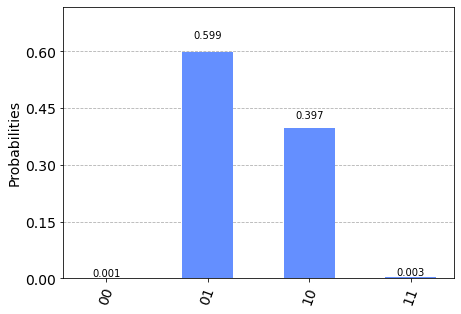

Number of shots: 10, end point: [-1.68288377e+00 -7.09050894e-04 -1.11978623e+00  3.15993175e+00], remaining cost: 0.0, iterations: 239


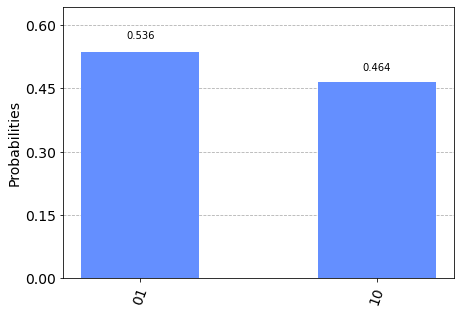

Number of shots: 100, end point: [-1.89764256e+00 -7.57879019e-04 -9.90595799e-01  3.13538976e+00], remaining cost: 0.20199999999999996, iterations: 521


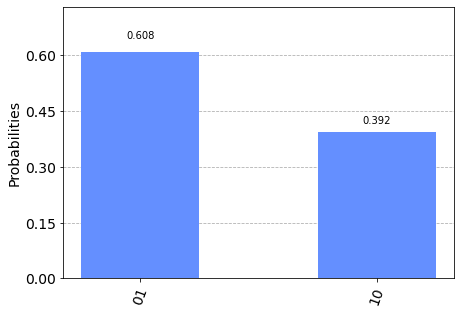

Number of shots: 1000, end point: [-1.82806903e+00 -2.26051574e-03 -1.01679639e+00  3.14041789e+00], remaining cost: 0.14199999999999996, iterations: 481


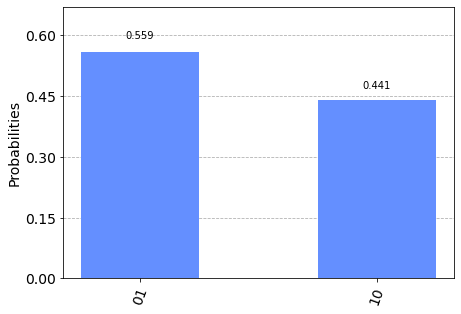

In [12]:
shot_numbers = [1, 10, 100, 1000]

def execute_sgd(shots, initial_point=[]):
    p, v, n = sgd(objective_function=objective_function, shots=shots, initial_point=initial_point)
    resulting_qc = variational_form(p)
    result = execute(resulting_qc, backend, shots=1000).result()
    print("Number of shots: {}, end point: {}, remaining cost: {}, iterations: {}".format(shots, p, v, n))
    return(plot_histogram(result.get_counts()))
    
for shot_number in shot_numbers:
    display(execute_sgd(shot_number, initial_point=initial_point))

### Bonus question
> How to make sure you produce state |01⟩ + |10⟩ and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩ - |10⟩)?

Assuming we are allowed to use domain knowledge about the state, we can drop the Rx gates, as they introduce phase $\varphi$ and thus introduce imaginary components in the amplitudes. Further, we can impose constraints on the parameters of the Ry gates: $\theta_1 \in [0, \pi/2]$, and $\theta_2 \in [0, \pi]$. This will ensure we stay on the "positive" side of the Bloch sphere.

However, if we're not allowed to use domain knowledge, making sure we produce state $|01⟩ + |10⟩$ and not any other combination can be only be achieved if the optimization criterion somehow takes into account the state vector _before_ measurement. Once we measure the state, all information about entanglement and phase will be lost. One way to do this would be to come up with a Hamiltonian whose smallest eigenvalue corresponds to $(|01⟩ + |10⟩) / \sqrt 2$ and use it in an algorithm such as VQE to optimize with respect to that.